# Latency and Scalability Testing Exercise
Objective
The purpose of this exercise is to evaluate the model's performance under varying workloads, simulating real-world production loads. You will:

Measure response times under different loads.
Monitor resource utilization (CPU, memory).
Identify bottlenecks and performance degradation points.
Tools

JMeter: Simulates user requests and generates load on the model.
Python: Analyzes response data and monitors server metrics.
Prerequisites

Install Apache JMeter.
Set up the model API (deployed locally or on the cloud) to test.

### Tools
- JMeter: Tool for load testing and performance measurement.
- OS: Library for system-level operations and environment management.
- Pandas: Library for data analysis and manipulation.
- Matplotlib: Library for creating visualizations.
- Psutil: Library for monitoring system performance.
- Time: Library for measuring and controlling time-related

### Step 0: Install Dependencies
Install the required tools and libraries.

In [ ]:
# Install psutil for resource monitoring
!pip install psutil
!apt-get install openjdk-11-jdk-headless -qq > /dev/null  # Install Java for JMeter
!wget https://downloads.apache.org/jmeter/binaries/apache-jmeter-5.6.3.zip  # Download JMeter
!unzip apache-jmeter-5.6.3.zip
!rm apache-jmeter-5.6.3.zip
!chmod +x apache-jmeter-5.6.3/bin/jmeter

# Set JMeter path
import os
os.environ["PATH"] += ":/content/apache-jmeter-5.6.3/bin"

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import time

--2024-12-31 02:48:02--  https://downloads.apache.org/jmeter/binaries/apache-jmeter-5.6.3.zip
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90631635 (86M) [application/zip]
Saving to: ‘apache-jmeter-5.6.3.zip’

apache-jmeter-5.6.3 100%[===================>]  86.43M  27.2MB/s    in 3.2s    

2024-12-31 02:48:06 (27.2 MB/s) - ‘apache-jmeter-5.6.3.zip’ saved [90631635/90631635]

Archive:  apache-jmeter-5.6.3.zip
   creating: apache-jmeter-5.6.3/
  inflating: apache-jmeter-5.6.3/LICENSE  
   creating: apache-jmeter-5.6.3/licenses/
   creating: apache-jmeter-5.6.3/licenses/flot-axislabels/
   creating: apache-jmeter-5.6.3/licenses/flot-axislabels/flot-axislabels-0.8.3/
  inflating: apache-jmeter-5.6.3/licenses/flot-axislabels/flot-axislabels-0.8.3/LICENSE  
   creating: apache-jm

### Step 1: Create JMeter Test Plan
Define a JMeter test plan to simulate load:

- 5 threads (users) sending requests simultaneously.
- A ramp-up time of 2 seconds.
- 10 iterations targeting the public API endpoint: https://pokeapi.co/api/v2/pokemon/ditto

In [ ]:
# Writing a basic JMeter test plan to simulate API requests.
test_plan = """
<?xml version="1.0" encoding="UTF-8"?>
<jmeterTestPlan version="1.2" properties="5.0" jmeter="5.6.2">
  <hashTree>
    <TestPlan guiclass="TestPlanGui" testclass="TestPlan" testname="Test Plan" enabled="true">
      <stringProp name="TestPlan.comments"></stringProp>
      <boolProp name="TestPlan.functional_mode">false</boolProp>
      <boolProp name="TestPlan.tearDown_on_shutdown">true</boolProp>
      <elementProp name="TestPlan.user_defined_variables" elementType="Arguments" guiclass="ArgumentsPanel" testclass="Arguments" testname="User Defined Variables" enabled="true">
        <collectionProp name="Arguments.arguments"/>
      </elementProp>
      <stringProp name="TestPlan.serialize_threadgroups">false</stringProp>
    </TestPlan>
    <hashTree>
      <ThreadGroup guiclass="ThreadGroupGui" testclass="ThreadGroup" testname="Thread Group" enabled="true">
        <stringProp name="ThreadGroup.on_sample_error">continue</stringProp>
        <elementProp name="ThreadGroup.main_controller" elementType="LoopController" guiclass="LoopControlPanel" testclass="LoopController" testname="Loop Controller" enabled="true">
          <boolProp name="LoopController.continue_forever">false</boolProp>
          <stringProp name="LoopController.loops">10</stringProp>
        </elementProp>
        <stringProp name="ThreadGroup.num_threads">5</stringProp>
        <stringProp name="ThreadGroup.ramp_time">2</stringProp>
        <longProp name="ThreadGroup.start_time">1696363451000</longProp>
        <longProp name="ThreadGroup.end_time">1696363451000</longProp>
        <boolProp name="ThreadGroup.scheduler">false</boolProp>
        <stringProp name="ThreadGroup.duration"></stringProp>
        <stringProp name="ThreadGroup.delay"></stringProp>
      </ThreadGroup>
      <hashTree>
        <HTTPSamplerProxy guiclass="HttpTestSampleGui" testclass="HTTPSamplerProxy" testname="HTTP Request" enabled="true">
          <stringProp name="HTTPSampler.domain">pokeapi.co</stringProp>
          <stringProp name="HTTPSampler.port"></stringProp>
          <stringProp name="HTTPSampler.protocol">https</stringProp>
          <stringProp name="HTTPSampler.contentEncoding"></stringProp>
          <stringProp name="HTTPSampler.path">/api/v2/pokemon/ditto</stringProp>
          <stringProp name="HTTPSampler.method">GET</stringProp>
          <boolProp name="HTTPSampler.follow_redirects">true</boolProp>
          <boolProp name="HTTPSampler.auto_redirects">false</boolProp>
          <boolProp name="HTTPSampler.use_keepalive">true</boolProp>
          <boolProp name="HTTPSampler.DO_MULTIPART_POST">false</boolProp>
          <stringProp name="HTTPSampler.embedded_url_re"></stringProp>
          <stringProp name="HTTPSampler.connect_timeout"></stringProp>
          <stringProp name="HTTPSampler.response_timeout"></stringProp>
        </HTTPSamplerProxy>
        <hashTree/>
      </hashTree>
    </hashTree>
  </hashTree>
</jmeterTestPlan>
"""

# Write the JMeter test plan to a file
with open("test_plan.jmx", "w") as file:
    file.write(test_plan)

### Step 2: Run JMeter
Run the test plan to simulate user activity and gather results.

In [ ]:
# Execute JMeter
!jmeter -n -t test_plan.jmx -l test_results.jtl

WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
WARN StatusConsoleListener The use of package scanning to locate plugins is deprecated and will be removed in a future release
Creating summariser <summary>
Created the tree successfully using test_plan.jmx
Starting standalone test @ 2024 Dec 31 03:38:05 UTC (1735616285617)
Waiting for possible Shutdown/StopTestNow/HeapDump/ThreadDump message on port 4445
summary =     50 in 00:00:02 =   26.8/s Avg:    34 Min:    10 Max:   550 Err:     0 (0.00%)
Tidying up ...    @ 2024 Dec 31 03:38:08 UTC (1735616288246)
... end of run


### Step 3: Analyze Results
Load and visualize the test results. Plot response times against timestamps to observe API behavior under load.

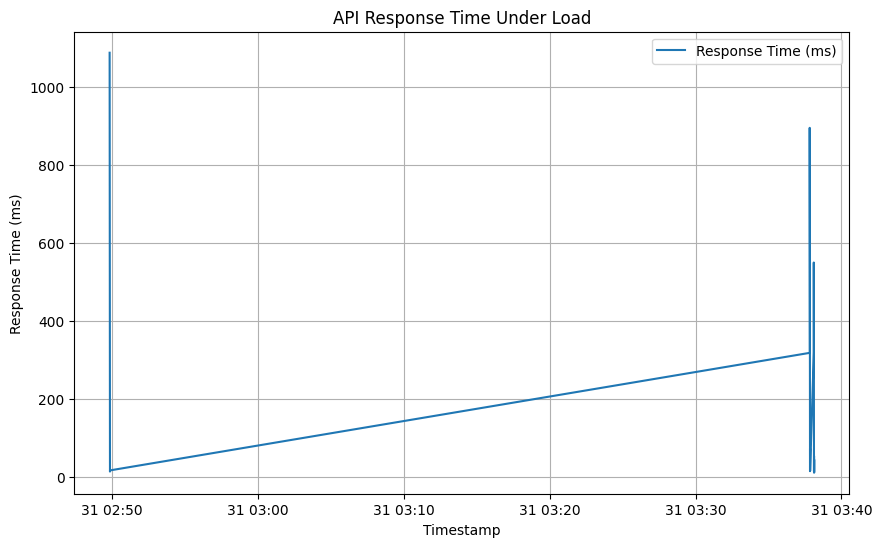

In [ ]:
# Load test results
results = pd.read_csv("test_results.jtl", sep=",", skiprows=1)
results.columns = ["timeStamp", "elapsed", "label", "responseCode", "responseMessage", "threadName", "dataType", "success", "bytes", "failureMessage", "sentBytes", "grpThreads", "allThreads", "URL", "Latency", "IdleTime", "Connect"]

# Convert timestamps to datetime
results["timeStamp"] = pd.to_datetime(results["timeStamp"], unit="ms")

# Plot response time
plt.figure(figsize=(10, 6))
plt.plot(results["timeStamp"], results["elapsed"], label="Response Time (ms)")
plt.xlabel("Timestamp")
plt.ylabel("Response Time (ms)")
plt.title("API Response Time Under Load")
plt.legend()
plt.grid()
plt.show()

### Questions:

1. Observe the response time plot. Are there spikes, drops, or patterns in the response times?
2. How does the system handle steady-state load after the initial spike?

### Step 4: Monitor Resource Utilization
Monitor and visualize CPU and memory usage during the test to identify potential resource constraints.

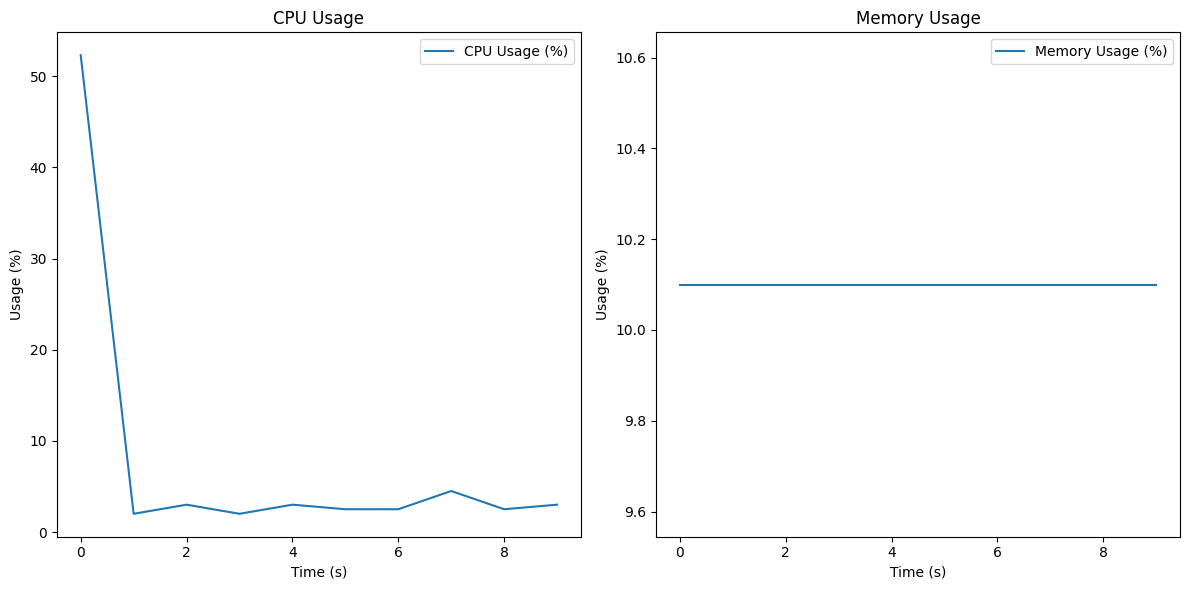

In [ ]:
# Monitor CPU and memory usage
cpu_usage = []
memory_usage = []

for _ in range(10):
    cpu_usage.append(psutil.cpu_percent(interval=1))
    memory_usage.append(psutil.virtual_memory().percent)

# Plot CPU and Memory usage
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cpu_usage, label="CPU Usage (%)")
plt.title("CPU Usage")
plt.xlabel("Time (s)")
plt.ylabel("Usage (%)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(memory_usage, label="Memory Usage (%)")
plt.title("Memory Usage")
plt.xlabel("Time (s)")
plt.ylabel("Usage (%)")
plt.legend()

plt.tight_layout()
plt.show()

### Questions:
1. Examine the CPU and memory usage plots. What do you observe about resource utilization during the load test?
2. Are there any unexpected spikes or patterns in resource usage?
